In [1]:
# analysis on-hold
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import sys
sys.path.append('/Users/dbao/Downloads/research/rc_scripts/analysis')

from final_analysis.process_helper.df_choice_add_features import df_choice_add_features
from final_analysis.process_helper.df_undo_start_end import df_undo_start_end
import final_analysis.plot_helper.format
save_mode = ".pdf"

In [3]:
%load_ext rpy2.ipython

from rpy2.robjects.packages import importr
# import R's "base" package
lme4 = importr('lme4')
mass = importr('MASS')
rcompanion = importr('rcompanion')

/Users/dbao/opt/anaconda3/envs/road/lib/python3.8/site-packages/rpy2/robjects/pandas2ri.py:14: FutureWarning: pandas.core.index is deprecated and will be removed in a future version. The public classes are available in the top-level namespace.
  from pandas.core.index import Index as PandasIndex


# load data

In [6]:
home_dir = '/Users/dbao/Library/CloudStorage/GoogleDrive-sherrydbao@gmail.com/.shortcut-targets-by-id/1sYZNVBbYCrHcHjo-9xdKcA4wLnob9ZEq/'+'/road_construction/data/2022_online/'
data_dir = home_dir + 'R_analysis_data/'
out_dir = home_dir + 'figures/figures_final/'
out_dir2 = home_dir + 'stat_model/final/'

In [7]:
data_choice_level = pd.read_csv(data_dir +  'choice_level/choicelevel_data.csv') # first column is index  
data_choice_level = data_choice_level.rename(columns={'Unnamed: 0':'index_copy'})
data_choice_level = df_choice_add_features(data_choice_level)
sc_data_choice_level = data_choice_level[data_choice_level['condition']==1].reset_index(drop=True) 

# error magnitude before undo

In [8]:
condition = f"(lastUndo == 1)"
accu_error = df_undo_start_end(sc_data_choice_level, condition)

accu_error['undo_right'] = (accu_error.category==1)
accu_error['undo_too_many'] = (accu_error.category==0)
accu_error['undo_too_few'] = (accu_error.category==2)

In [9]:
accu_error = accu_error[(accu_error.error_count_beginning<=1)&(accu_error.cum_error_beginning>0)]
undo_right_sub = accu_error.groupby(['subjects','cum_error_beginning'])['undo_right'].mean().reset_index()
undo_right_sub.groupby(['cum_error_beginning'])['undo_right'].count()

cum_error_beginning
1    82
2    81
3    56
4    29
5     3
6     1
Name: undo_right, dtype: int64

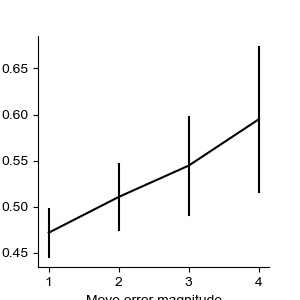

In [13]:
%matplotlib widget
fig, axs = plt.subplots(1, 1)
fig.set_size_inches(3, 3)

sns.lineplot(x='cum_error_beginning', y='undo_right',
                data = undo_right_sub[undo_right_sub.cum_error_beginning<=4],
                color = 'black', #'#8da0cb'
                err_style = "bars",
                errorbar = "se")

axs.set_xticks([1,2,3,4])

axs.set(xlabel='Move error magnitude', ylabel='Proportion of on-target undo')
axs.set_aspect(1/axs.get_data_ratio())
plt.show()
fig.savefig(out_dir+'undo_right_error'+save_mode, dpi=300, bbox_inches='tight')

In [10]:
%%R -i accu_error,out_dir2
accu_error$subjects <- as.factor(accu_error[,"subjects"])
accu_error$error_beginning <- scale(accu_error$error_beginning)
accu_error$cum_error_beginning <- scale(accu_error$cum_error_beginning)
accu_error$puzzleID <- as.factor(accu_error[,"puzzleID"])

model_undo_right = lme4::glmer(undo_right ~  1 + cum_error_beginning + (1 |subjects) + (1 | puzzleID),
                                  data = accu_error, 
                                  family = binomial(link="logit"))
summary(model_undo_right)
# save(model_undo_right, accu_error, file=file.path(out_dir2, file=paste("model_undo_right_error_and_cumulative.RData", sep="")))

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: undo_right ~ 1 + cum_error_beginning + (1 | subjects) + (1 |  
    puzzleID)
   Data: accu_error

     AIC      BIC   logLik deviance df.resid 
  2522.0   2544.3  -1257.0   2514.0     1904 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-1.8353 -0.8359 -0.4949  0.9113  2.5820 

Random effects:
 Groups   Name        Variance Std.Dev.
 subjects (Intercept) 0.3628   0.6024  
 puzzleID (Intercept) 0.2844   0.5333  
Number of obs: 1908, groups:  subjects, 90; puzzleID, 46

Fixed effects:
                    Estimate Std. Error z value Pr(>|z|)    
(Intercept)         -0.10496    0.12092  -0.868    0.385    
cum_error_beginning  0.23175    0.05326   4.352 1.35e-05 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
            (Intr)
cm_rrr_bgnn -0.003


cum_error_beginning
1    82
2    81
3    56
4    29
5     3
6     1
Name: undo_too_few, dtype: int64


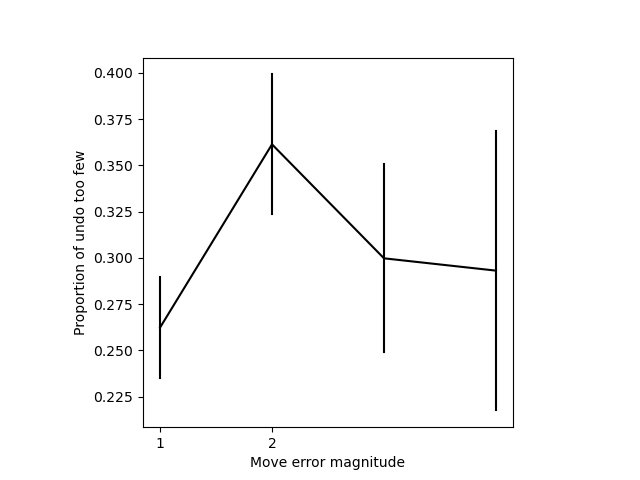

In [25]:
undo_too_few_sub = accu_error.groupby(['subjects','cum_error_beginning'])['undo_too_few'].mean().reset_index()
print(undo_too_few_sub.groupby(['cum_error_beginning'])['undo_too_few'].count())

%matplotlib widget
fig, axs = plt.subplots(1, 1)

sns.lineplot(x='cum_error_beginning', y='undo_too_few',
                data = undo_too_few_sub[undo_too_few_sub.cum_error_beginning<=4],
                color = 'black', #'#8da0cb'
                err_style = "bars",
                errorbar = "se")

axs.set_xticks([1,2])

axs.set(xlabel='Move error magnitude', ylabel='Proportion of undo too few')
axs.set_aspect(1/axs.get_data_ratio())
plt.show()

In [27]:
%%R

model_undo_too_many = lme4::glmer(undo_too_many ~  1 + cum_error_beginning + (1 |subjects) + (1 | puzzleID),
                                  data = accu_error, 
                                  family = binomial(link="logit"))
print(summary(model_undo_too_many))

model_undo_too_few = lme4::glmer(undo_too_few ~  1 + cum_error_beginning + (1 |subjects) + (1 | puzzleID),
                                  data = accu_error, 
                                  family = binomial(link="logit"))
print(summary(model_undo_too_few))


Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: undo_too_many ~ 1 + cum_error_beginning + (1 | subjects) + (1 |  
    puzzleID)
   Data: accu_error

     AIC      BIC   logLik deviance df.resid 
  1932.9   1955.1   -962.4   1924.9     1904 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-1.6661 -0.5446 -0.3727 -0.1202  7.3202 

Random effects:
 Groups   Name        Variance Std.Dev.
 subjects (Intercept) 0.6050   0.7778  
 puzzleID (Intercept) 0.6801   0.8247  
Number of obs: 1908, groups:  subjects, 90; puzzleID, 46

Fixed effects:
                    Estimate Std. Error z value Pr(>|z|)    
(Intercept)         -1.52313    0.17452  -8.728  < 2e-16 ***
cum_error_beginning -0.44005    0.07385  -5.959 2.55e-09 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
            (Intr)
cm_rrr_bgnn 0.081 
Generalized linear mixed model fit by maximu